# Deep Q-learning for GridWorld - Complete code


In [1]:
import numpy as np
import torch
import torch.nn as nn
import random
from collections import deque
import matplotlib.pyplot as plt
from IPython.display import clear_output
from Gridworld import Gridworld
import copy
import os

##### Vanilla Model

In [2]:
action_set = {
    0: 'u',
    1: 'd',
    2: 'l',
    3: 'r',
}

##### Function to test the model

##### Experience Replay to eliminate Catastrophic forgetting

In [3]:
l1 = 29
l2 = 64
l3 = 128
l4 = 64
l5 = 5

model = torch.nn.Sequential(
    torch.nn.Linear(l1, l2),
    torch.nn.ReLU(),
    torch.nn.Linear(l2, l3),
    torch.nn.ReLU(),
    torch.nn.Linear(l3,l4),
    torch.nn.ReLU(),
    torch.nn.Linear(l4,l5)
)
loss_fn = torch.nn.MSELoss()
learning_rate = 1e-3
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

learning_rate = 1e-3
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

gamma = 0.9
epsilon = 0.3

###### Target network to handle learning instability

## DQN Training with Experience Replay and Target Network

In [4]:
# Create main network and target network
model2 = copy.deepcopy(model)  # Target network

# Loss function and optimizer
loss_fn = torch.nn.MSELoss()
learning_rate = 1e-3
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

# Training hyperparameters
gamma = 0.99      # Discount factor
epsilon = 1.0     # Initial exploration rate
epsilon_min = 0.1 # Minimum exploration rate
epsilon_decay = 0.995  # Decay rate for exploration

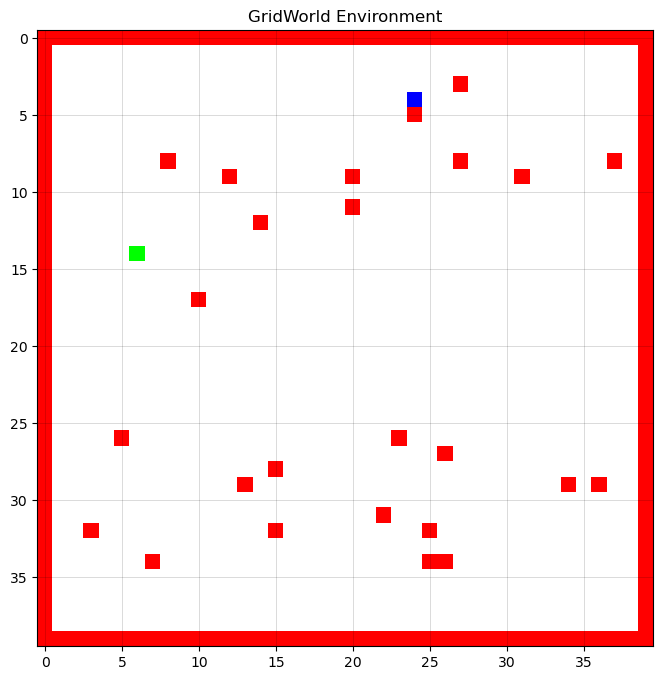

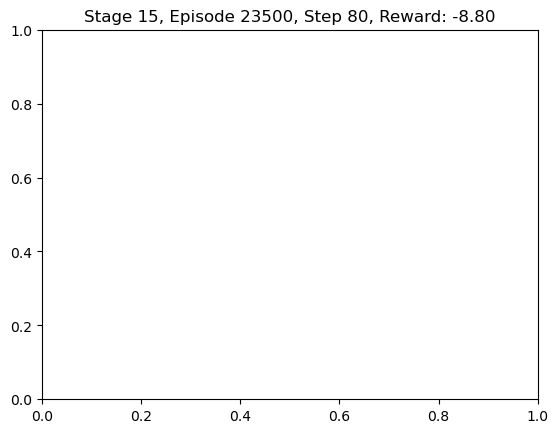

Episode 23500: Success! Reward: -8.80, Steps: 80
Checkpoint saved at episode 23500
Episode 23501: Success! Reward: -5.00, Steps: 80
Episode 23502: Success! Reward: -8.00, Steps: 80
Episode 23503: Success! Reward: -8.00, Steps: 80
Episode 23504: Success! Reward: -8.40, Steps: 80
Episode 23505: Success! Reward: -8.60, Steps: 80
Episode 23506: Success! Reward: -8.40, Steps: 80
Episode 23507: Success! Reward: -8.80, Steps: 80
Episode 23508: Success! Reward: -7.20, Steps: 80
Episode 23509: Success! Reward: -7.80, Steps: 80
Episode 23510: Success! Reward: -8.20, Steps: 80
Episode 23511: Success! Reward: -4.80, Steps: 80
Target network updated at step 1186000
Episode 23512: Success! Reward: -10.80, Steps: 80
Episode 23513: Success! Reward: -4.40, Steps: 80
Episode 23514: Success! Reward: -8.60, Steps: 80
Episode 23515: Success! Reward: -8.00, Steps: 80
Episode 23516: Success! Reward: -5.00, Steps: 80
Episode 23517: Success! Reward: -12.00, Steps: 80
Episode 23518: Success! Reward: -11.40, Ste

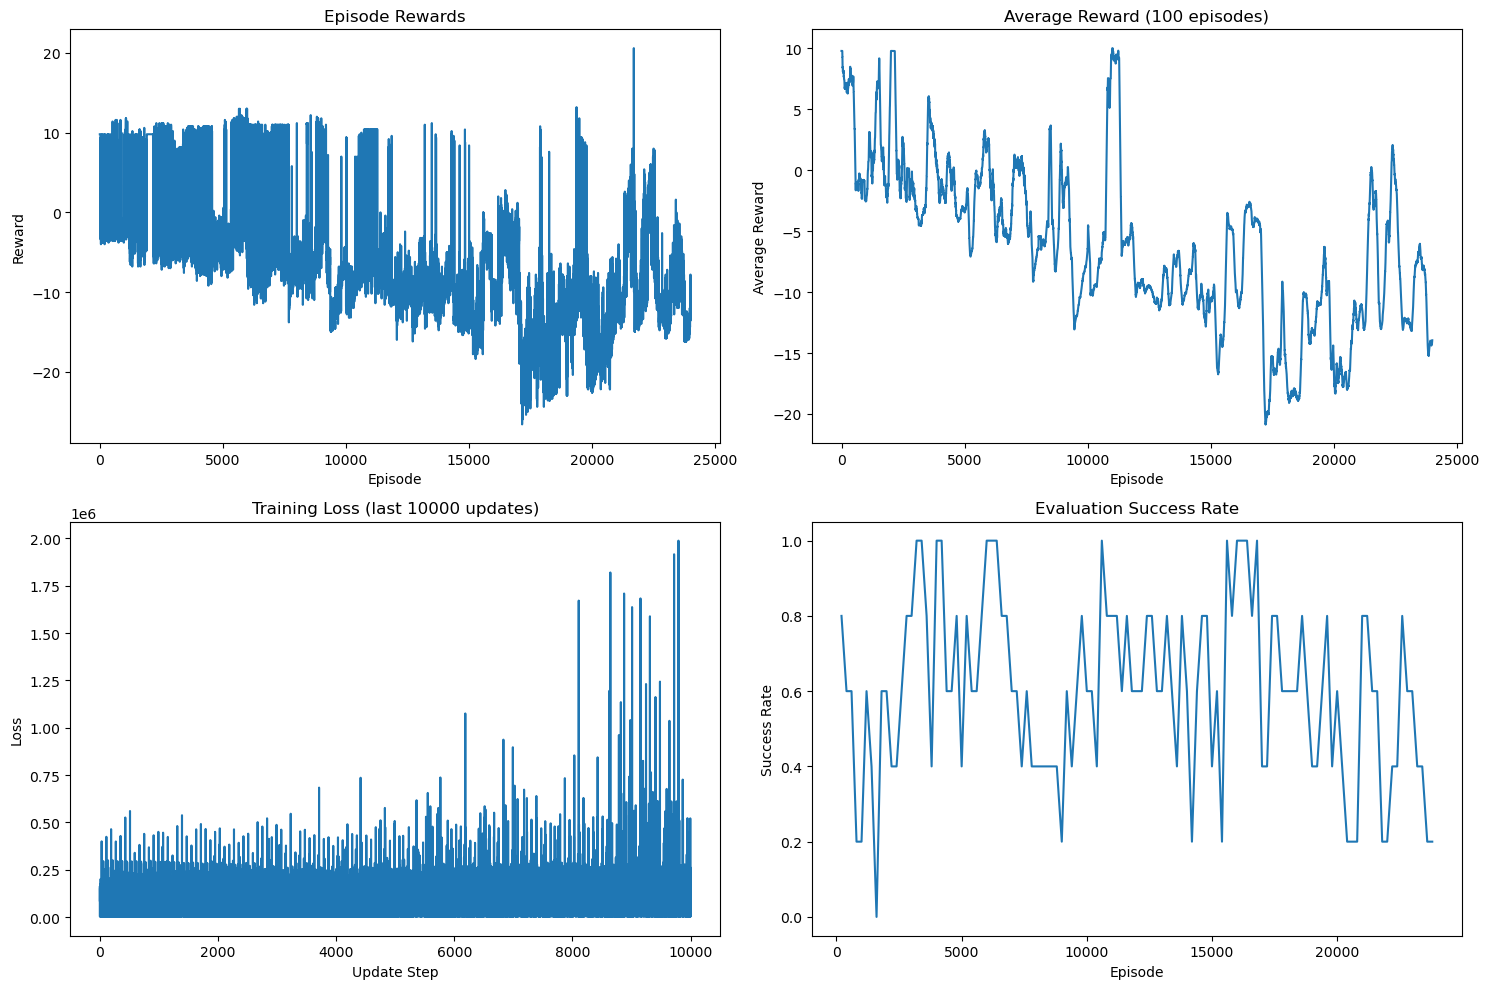

Training completed. Final model saved.


In [5]:
# Enhanced Compound Training Function
def train_compound(epochs=24000, batch_size=64, memory_size=150000, render_interval=500):
    # Initialize metrics tracking
    losses = []
    all_rewards = []
    avg_rewards = []
    success_rates = []
    best_eval_score = float('-inf')
    best_model_state = None
    
    # Create replay memory
    replay = deque(maxlen=memory_size)
    
    # Create model checkpoint directory
    os.makedirs('models', exist_ok=True)

    # Initialize epsilon for exploration
    epsilon = 1.0
    epsilon_min = 0.05
    epsilon_decay_rate = 0.99995  # Slower decay for more exploration
    
    # Enhanced curriculum with more intermediate stages and higher obstacle density
    curriculum = [
        # Stage 1: Very small grids (5x5) with minimal obstacles
        {'episodes': int(epochs * 0.02), 'grid_sizes': [5], 'obstacles': (1, 3), 'patterns': ['random'], 
        'max_steps_factor': 3.5, 'epsilon_min': 0.2},
        
        # Stage 2: Small grids (6x6) with increasing obstacles
        {'episodes': int(epochs * 0.03), 'grid_sizes': [6], 'obstacles': (2, 4), 'patterns': ['random'], 
        'max_steps_factor': 3.5, 'epsilon_min': 0.18},
        
        # Stage 3: Small grids (7x7, 8x8) with more obstacles
        {'episodes': int(epochs * 0.04), 'grid_sizes': [7, 8], 'obstacles': (3, 6), 'patterns': ['random'], 
        'max_steps_factor': 3.2, 'epsilon_min': 0.16},
        
        # Stage 4: Early medium grids (9x9, 10x10) with moderate obstacles
        {'episodes': int(epochs * 0.05), 'grid_sizes': [9, 10], 'obstacles': (4, 8), 'patterns': ['random'], 
        'max_steps_factor': 3.0, 'epsilon_min': 0.15},
        
        # Stage 5: Medium grids (11x11, 12x12) with clusters
        {'episodes': int(epochs * 0.05), 'grid_sizes': [11, 12], 'obstacles': (5, 10), 'patterns': ['random'],
        'max_steps_factor': 2.8, 'epsilon_min': 0.14},
        
        # Stage 6: Larger medium grids (13x13, 14x14) with more obstacles
        {'episodes': int(epochs * 0.06), 'grid_sizes': [13, 14], 'obstacles': (8, 14), 'patterns': ['random'],
        'max_steps_factor': 2.8, 'epsilon_min': 0.13},
        
        # Stage 7: Medium-large grids (15x15, 16x16) with substantial obstacles 
        {'episodes': int(epochs * 0.07), 'grid_sizes': [15, 16], 'obstacles': (10, 15), 'patterns': ['random'],
        'max_steps_factor': 2.6, 'epsilon_min': 0.12},
        
        # Stage 8: Large medium grids (17x17, 18x18) introducing walls pattern
        {'episodes': int(epochs * 0.07), 'grid_sizes': [17, 18], 'obstacles': (12, 16), 'patterns': ['random'],
        'max_steps_factor': 2.6, 'epsilon_min': 0.11},
        
        # Stage 9: First large grids (19x19, 20x20) with challenging obstacles
        {'episodes': int(epochs * 0.08), 'grid_sizes': [19, 20], 'obstacles': (15, 18), 'patterns': ['random'],
        'max_steps_factor': 2.5, 'epsilon_min': 0.10},
        
        # Stage 10: Growing large grids (22x22, 24x24) with dense obstacles
        {'episodes': int(epochs * 0.08), 'grid_sizes': [22, 24], 'obstacles': (18, 20), 'patterns': ['random'],
        'max_steps_factor': 2.4, 'epsilon_min': 0.09},
        
        # Stage 11: Large grids (25x25, 27x27) with very high obstacle count
        {'episodes': int(epochs * 0.08), 'grid_sizes': [25, 27], 'obstacles': (21, 24), 'patterns': ['random'],
        'max_steps_factor': 2.3, 'epsilon_min': 0.08},
        
        # Stage 12: Very large grids (30x30) with maze-like obstacles
        {'episodes': int(epochs * 0.08), 'grid_sizes': [30], 'obstacles': (24, 30), 'patterns': ['random'],
        'max_steps_factor': 2.2, 'epsilon_min': 0.07},
        
        # Stage 13: Larger grids (33x33, 35x35) with high obstacle density
        {'episodes': int(epochs * 0.08), 'grid_sizes': [33, 35], 'obstacles': (25, 35), 'patterns': ['random'],
        'max_steps_factor': 2.1, 'epsilon_min': 0.06},
        
        # Stage 14: Extremely large grids (38x38) with extreme obstacles
        {'episodes': int(epochs * 0.08), 'grid_sizes': [38], 'obstacles': (30, 40), 'patterns': ['random'],
        'max_steps_factor': 2.0, 'epsilon_min': 0.055},
        
        # Stage 15: Maximum challenge (40x40) with highest obstacle density
        {'episodes': int(epochs * 0.13), 'grid_sizes': [40], 'obstacles': (20, 50), 'patterns': ['random'],
        'max_steps_factor': 2.0, 'epsilon_min': 0.05}
    ]
    
    # Setup for periodic evaluation
    eval_interval = 200  # Evaluate model every 200 episodes
    eval_episodes = 20   # Number of episodes to use for evaluation
    
    # Validation environments for consistent evaluation
    validation_envs = [
        # Simple validation environments
        (10, 5, 'random'),   # (grid_size, obstacles, pattern)
        (15, 10, 'random'),
        (20, 15, 'clusters'),
        (30, 20, 'walls'),
        (40, 30, 'random')
    ]

    # Define sync frequency for target network updates (steps)
    sync_freq = 1000
    
    # Global step counter
    global_step = 0
    episode_count = 0
    
    print("Starting compound training with curriculum learning...")
    
    # Loop through curriculum stages
    for stage_idx, stage in enumerate(curriculum):
        print(f"\n===== Starting Stage {stage_idx + 1}/{len(curriculum)} =====")
        print(f"Grid sizes: {stage['grid_sizes']}")
        print(f"Obstacles: {stage['obstacles']}")
        print(f"Patterns: {stage['patterns']}")
        print(f"Episodes: {stage['episodes']}")
        
        # Update epsilon min for this stage
        stage_epsilon_min = stage['epsilon_min']
        
        # Reset epsilon for new stage if needed (optional - keep this line if you want epsilon reset per stage)
        epsilon = max(1.0 - stage_idx * 0.1, 0.5)  # Start with less exploration in later stages
        
        # Track episodes in this stage
        stage_episodes = 0
        
        # Continue until we've completed the designated episodes for this stage
        while stage_episodes < stage['episodes'] and episode_count < epochs:
            # Select random parameters for this episode
            grid_size = random.choice(stage['grid_sizes'])
            num_obstacles = random.randint(stage['obstacles'][0], stage['obstacles'][1])
            pattern = random.choice(stage['patterns'])
            
            # Create environment for this episode
            max_steps = int(grid_size * stage['max_steps_factor'])  # Scale max steps with grid size
            game = Gridworld(size=grid_size, mode=pattern, num_obstacles=num_obstacles, max_steps=max_steps)
            
            # Initialize state
            state = game.reset()
            state = torch.from_numpy(state).float().unsqueeze(0)  # Add batch dimension
            
            done = False
            steps = 0
            episode_reward = 0
            success = False
            
            # Display info periodically
            should_render = (episode_count % render_interval == 0)
            
            if episode_count % 50 == 0:
                print(f"Episode {episode_count}/{epochs} (Stage {stage_idx+1}, Ep {stage_episodes}/{stage['episodes']})")
                print(f"Grid: {grid_size}x{grid_size}, Obstacles: {num_obstacles}, Pattern: {pattern}")
                print(f"Epsilon: {epsilon:.4f}, Memory: {len(replay)}/{memory_size}")
            
            # Run episode
            while not done and steps < max_steps:
                steps += 1
                global_step += 1
                
                # Epislon-greedy action selection
                if random.random() < epsilon:
                    action = random.randint(0, 4)  # Random action
                else:
                    with torch.no_grad():
                        q_values = model(state)
                        action = torch.argmax(q_values).item()  # Greedy action
                
                # Take action in environment
                next_state, reward, done, info = game.step(action)
                next_state = torch.from_numpy(next_state).float().unsqueeze(0)
                
                # Record success if goal reached
                if reward > 0:  # Assuming positive reward means goal reached
                    success = True
                
                # Store in replay memory
                replay.append((state, action, reward, next_state, done))
                
                # Update state and accumulate reward
                state = next_state
                episode_reward += reward
                
                # Render if needed
                if should_render and steps % 5 == 0:
                    clear_output(wait=True)
                    game.render()
                    plt.title(f"Stage {stage_idx+1}, Episode {episode_count}, Step {steps}, Reward: {episode_reward:.2f}")
                    plt.pause(0.1)
                
                # Training step (if we have enough samples)
                if len(replay) >= batch_size:
                    # Sample mini-batch
                    minibatch = random.sample(replay, batch_size)
                    
                    # Extract batch components
                    state_batch = torch.cat([s1 for (s1, _, _, _, _) in minibatch])
                    action_batch = torch.tensor([a for (_, a, _, _, _) in minibatch], dtype=torch.long)
                    reward_batch = torch.tensor([r for (_, _, r, _, _) in minibatch], dtype=torch.float)
                    next_state_batch = torch.cat([s2 for (_, _, _, s2, _) in minibatch])
                    done_batch = torch.tensor([d for (_, _, _, _, d) in minibatch], dtype=torch.float)
                    
                    # Compute current Q values
                    current_Q = model(state_batch).gather(1, action_batch.unsqueeze(1)).squeeze(1)
                    
                    # Double DQN: Use online network to select actions, target network to evaluate
                    with torch.no_grad():
                        # Find best actions using online model
                        best_actions = model(next_state_batch).max(1)[1].unsqueeze(1)
                        # Evaluate those actions using target model
                        next_Q = model2(next_state_batch).gather(1, best_actions).squeeze(1)
                        # Compute target Q values
                        target_Q = reward_batch + gamma * next_Q * (1 - done_batch)
                    
                    # Compute loss and update model
                    loss = loss_fn(current_Q, target_Q)
                    optimizer.zero_grad()
                    loss.backward()
                    
                    # Gradient clipping to prevent exploding gradients
                    torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=10.0)
                    
                    optimizer.step()
                    
                    # Store loss
                    losses.append(loss.item())
                
                # Update target network
                if global_step % sync_freq == 0:
                    model2.load_state_dict(model.state_dict())
                    print(f"Target network updated at step {global_step}")
            
            # Episode completed
            all_rewards.append(episode_reward)
            
            # Calculate running average reward
            window_size = min(100, len(all_rewards))
            avg_reward = sum(all_rewards[-window_size:]) / window_size
            avg_rewards.append(avg_reward)
            
            # Print episode results
            if success:
                print(f"Episode {episode_count}: Success! Reward: {episode_reward:.2f}, Steps: {steps}")
            elif episode_count % 50 == 0:
                print(f"Episode {episode_count}: Failed. Reward: {episode_reward:.2f}, Steps: {steps}")
            
            # Evaluate periodically
            if episode_count % eval_interval == 0 and episode_count > 0:
                print("\nRunning evaluation...")
                eval_success_rate, eval_avg_reward = evaluate_model(model, validation_envs, episodes_per_env=eval_episodes)
                success_rates.append(eval_success_rate)
                
                print(f"Evaluation - Success rate: {eval_success_rate:.2f}, Avg reward: {eval_avg_reward:.2f}")
                
                # Save best model
                eval_score = eval_success_rate * 10 + eval_avg_reward  # Combined metric
                if eval_score > best_eval_score:
                    best_eval_score = eval_score
                    best_model_state = model.state_dict().copy()
                    print(f"New best model with eval score {eval_score:.2f}!")
                    
                    # Save best model
                    torch.save({
                        'model_state_dict': model.state_dict(),
                        'optimizer_state_dict': optimizer.state_dict(),
                        'epsilon': epsilon,
                        'episode': episode_count,
                        'eval_score': eval_score,
                        'success_rate': eval_success_rate,
                        'avg_reward': eval_avg_reward,
                    }, 'models/dqn_best.pth')
            
            # Checkpoint model periodically
            if episode_count % 500 == 0 and episode_count > 0:
                torch.save({
                    'model_state_dict': model.state_dict(),
                    'optimizer_state_dict': optimizer.state_dict(),
                    'epsilon': epsilon,
                    'episode': episode_count,
                    'stage': stage_idx,
                    'all_rewards': all_rewards,
                    'avg_rewards': avg_rewards,
                    'losses': losses,
                }, f'models/dqn_checkpoint_ep{episode_count}.pth')
                print(f"Checkpoint saved at episode {episode_count}")
            
            # Decay epsilon - but respect the minimum for this stage
            epsilon = max(stage_epsilon_min, epsilon * epsilon_decay_rate)
            
            # Increment counters
            episode_count += 1
            stage_episodes += 1
        
        # End of stage - evaluate and save stage model
        print(f"\n===== Completed Stage {stage_idx + 1}/{len(curriculum)} =====")
        stage_eval_success, stage_eval_reward = evaluate_model(model, validation_envs, episodes_per_env=eval_episodes)
        
        print(f"Stage {stage_idx+1} Evaluation - Success rate: {stage_eval_success:.2f}, Avg reward: {stage_eval_reward:.2f}")
        
        # Save stage model
        torch.save({
            'model_state_dict': model.state_dict(),
            'optimizer_state_dict': optimizer.state_dict(),
            'epsilon': epsilon,
            'episode': episode_count,
            'stage': stage_idx,
            'success_rate': stage_eval_success,
            'avg_reward': stage_eval_reward,
        }, f'models/dqn_stage{stage_idx+1}.pth')
    
    # Training complete - final evaluation with best model
    print("\n===== Training Complete =====")
    
    # Load best model for final evaluation
    if best_model_state is not None:
        model.load_state_dict(best_model_state)
        print("Loaded best model for final evaluation")
    
    # Comprehensive final evaluation
    print("\nRunning final evaluation...")
    final_success_rate, final_avg_reward = evaluate_model(model, validation_envs, episodes_per_env=50)  # More episodes for final eval
    
    print(f"Final Evaluation - Success rate: {final_success_rate:.2f}, Avg reward: {final_avg_reward:.2f}")
    
    # Plot training metrics
    plt.figure(figsize=(15, 10))
    
    plt.subplot(2, 2, 1)
    plt.plot(all_rewards)
    plt.title('Episode Rewards')
    plt.xlabel('Episode')
    plt.ylabel('Reward')
    
    plt.subplot(2, 2, 2)
    plt.plot(avg_rewards)
    plt.title('Average Reward (100 episodes)')
    plt.xlabel('Episode')
    plt.ylabel('Average Reward')
    
    plt.subplot(2, 2, 3)
    plt.plot(losses[-10000:])  # Plot last 10000 losses to see recent trends
    plt.title('Training Loss (last 10000 updates)')
    plt.xlabel('Update Step')
    plt.ylabel('Loss')
    
    if success_rates:
        plt.subplot(2, 2, 4)
        # Generate x values that match exactly with the length of success_rates
        eval_points = np.arange(eval_interval, eval_interval * (len(success_rates) + 1), eval_interval)[:len(success_rates)]
        plt.plot(eval_points, success_rates)
        plt.title('Evaluation Success Rate')
        plt.xlabel('Episode')
        plt.ylabel('Success Rate')
    
    plt.tight_layout()
    plt.savefig('models/training_curves.png')
    plt.show()
    
    # Save final model
    torch.save({
        'model_state_dict': model.state_dict(),
        'optimizer_state_dict': optimizer.state_dict(),
        'epsilon': epsilon,
        'episode': episode_count,
        'final_success_rate': final_success_rate,
        'final_avg_reward': final_avg_reward,
    }, 'models/dqn_final.pth')
    
    # Return relevant data for analysis
    return {
        'model': model,
        'rewards': all_rewards,
        'avg_rewards': avg_rewards,
        'losses': losses,
        'success_rates': success_rates,
        'final_success_rate': final_success_rate,
        'final_avg_reward': final_avg_reward,
        'best_eval_score': best_eval_score
    }

def evaluate_model(model, env_configs, episodes_per_env=10):
    """
    Evaluate model on multiple environment configurations
    
    Args:
        model: The DQN model to evaluate
        env_configs: List of tuples (grid_size, num_obstacles, pattern)
        episodes_per_env: Number of episodes to run for each environment config
        
    Returns:
        Tuple of (success_rate, average_reward)
    """
    model.eval()  # Set model to evaluation mode
    success_count = 0
    total_rewards = []
    total_episodes = len(env_configs) * episodes_per_env
    
    with torch.no_grad():  # No need to track gradients during evaluation
        for grid_size, num_obstacles, pattern in env_configs:
            print(f"Evaluating on grid {grid_size}x{grid_size}, {num_obstacles} obstacles, {pattern} pattern")
            
            for ep in range(episodes_per_env):
                # Create environment
                max_steps = grid_size * 2
                game = Gridworld(size=grid_size, mode=pattern, num_obstacles=num_obstacles, max_steps=max_steps)
                
                state = game.reset()
                state = torch.from_numpy(state).float().unsqueeze(0)
                
                done = False
                steps = 0
                episode_reward = 0
                success = False
                
                while not done and steps < max_steps:
                    steps += 1
                    
                    # Get action from model - no exploration during evaluation
                    q_values = model(state)
                    action = torch.argmax(q_values).item()
                    
                    # Take action
                    next_state, reward, done, info = game.step(action)
                    next_state = torch.from_numpy(next_state).float().unsqueeze(0)
                    
                    # Update state and reward
                    state = next_state
                    episode_reward += reward
                    
                    # Check for success
                    if reward > 0:  # Positive reward means goal reached
                        success = True
                        break
                
                # Record results
                if success:
                    success_count += 1
                total_rewards.append(episode_reward)
    
    # Calculate final metrics
    success_rate = success_count / total_episodes
    avg_reward = sum(total_rewards) / len(total_rewards)
    
    model.train()  # Set model back to training mode
    return success_rate, avg_reward

epochs = 24000
results = train_compound(epochs=epochs, batch_size=64, memory_size=50000, render_interval=500)
model = results['model']

# Save final model
torch.save({
    'model_state_dict': model.state_dict(),
    'optimizer_state_dict': optimizer.state_dict(),
    'epsilon': epsilon,
    'episode': epochs,
}, 'models/dqn_final.pth')
print("Training completed. Final model saved.")

## Testing The Trained Model

<Figure size 1000x1000 with 0 Axes>

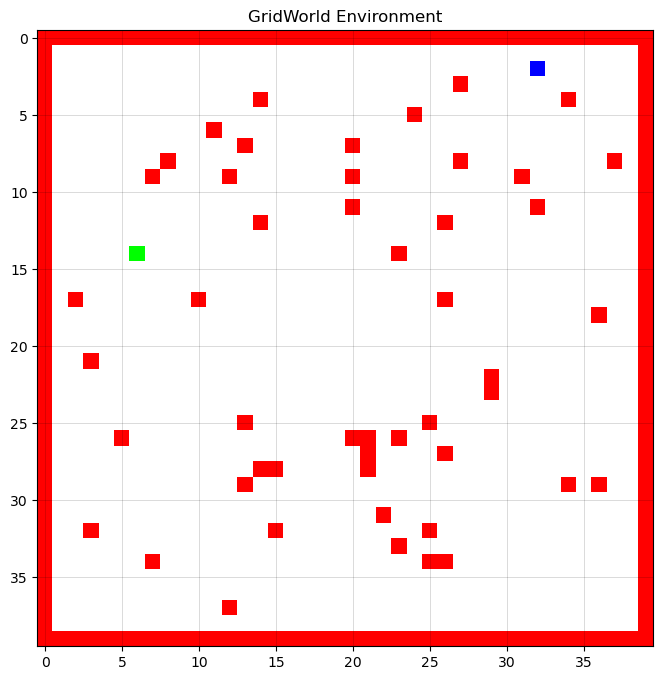

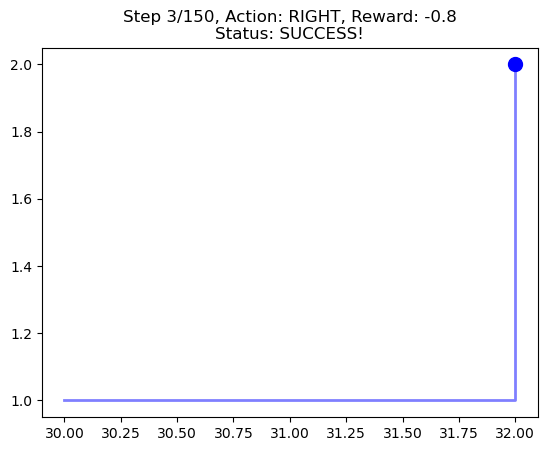


✅ SUCCESS! Goal reached in 3 steps with reward -0.8
Episode 2: ✅ SUCCESS with 49 obstacles, Steps: 3, Reward: -0.8
Episode 3: ✅ SUCCESS with 49 obstacles, Steps: 3, Reward: -0.8
Episode 4: ✅ SUCCESS with 49 obstacles, Steps: 3, Reward: -0.8
Episode 5: ✅ SUCCESS with 49 obstacles, Steps: 3, Reward: -0.8
Episode 6: ✅ SUCCESS with 49 obstacles, Steps: 3, Reward: -0.8
Episode 7: ✅ SUCCESS with 49 obstacles, Steps: 3, Reward: -0.8
Episode 8: ✅ SUCCESS with 49 obstacles, Steps: 3, Reward: -0.8
Episode 9: ✅ SUCCESS with 49 obstacles, Steps: 3, Reward: -0.8
Episode 10: ✅ SUCCESS with 49 obstacles, Steps: 3, Reward: -0.8
Episode 11: ✅ SUCCESS with 49 obstacles, Steps: 3, Reward: -0.8
Episode 12: ✅ SUCCESS with 49 obstacles, Steps: 3, Reward: -0.8
Episode 13: ✅ SUCCESS with 49 obstacles, Steps: 3, Reward: -0.8
Episode 14: ✅ SUCCESS with 49 obstacles, Steps: 3, Reward: -0.8
Episode 15: ✅ SUCCESS with 49 obstacles, Steps: 3, Reward: -0.8
Episode 16: ✅ SUCCESS with 49 obstacles, Steps: 3, Reward: 

In [13]:
# Simplified testing function with proper model definition
def test_model(model, obstacles=40, max_steps=150, render=True, pause_time=0.2):
    """
    Test the DQN model on a 40x40 grid with random obstacles
    
    Args:
        model: The DQN model to test
        obstacles: Number of obstacles (default 40)
        max_steps: Maximum steps allowed (default 150)
        render: Whether to render the environment (default True)
        pause_time: Time to pause between renders (default 0.2)
        
    Returns:
        bool: True if agent reached goal, False otherwise
        int: Number of steps taken
        float: Total reward accumulated
    """
    # Set model to evaluation mode
    model.eval()
    
    # Create environment - fixed at 40x40 with random pattern
    size = 40
    mode = 'random'
    game = Gridworld(size=size, mode=mode, num_obstacles=obstacles, max_steps=max_steps)
    
    # Initialize state
    state = game.reset()
    state = torch.tensor(state, dtype=torch.float32).unsqueeze(0)
    
    # Track agent's path for visualization
    path_history = [game.player_position]
    
    # Print initial positions if rendering
    if render:
        print(f"\nTesting on 40×40 grid with {obstacles} obstacles")
        print(f"Agent at {game.player_position}, Goal at {game.goal_position}")
        print(f"Manhattan distance: {abs(game.player_position[0] - game.goal_position[0]) + abs(game.player_position[1] - game.goal_position[1])}")
        
        # Initial render
        plt.figure(figsize=(10, 10))
        game.render()
        plt.title(f"Initial state - Agent at {game.player_position}, Goal at {game.goal_position}")
        plt.pause(pause_time)
    
    # Run episode
    done = False
    steps = 0
    total_reward = 0
    success = False
    
    while not done and steps < max_steps:
        # Select action
        with torch.no_grad():
            q_values = model(state)
            action = torch.argmax(q_values).item()
            action_name = ["UP", "RIGHT", "DOWN", "LEFT", "STAY"][action]
        
        # Take action
        next_state, reward, done, info = game.step(action)
        next_state = torch.tensor(next_state, dtype=torch.float32).unsqueeze(0)
        
        # Update state and tracking variables
        state = next_state
        total_reward += reward
        steps += 1
        
        # Track agent position
        path_history.append(game.player_position)
        
        # Check for success
        if reward > 0:  # Positive reward means reached goal
            success = True
            done = True
        
        # Render if requested
        if render and (steps % 2 == 0 or done):  # Render every other step
            clear_output(wait=True)
            plt.figure(figsize=(10, 10))
            game.render()
            
            # Draw path
            path_x = [pos[0] for pos in path_history]
            path_y = [pos[1] for pos in path_history]
            plt.plot(path_x, path_y, '-', color='blue', alpha=0.5, linewidth=2)
            plt.plot(path_x[-1], path_y[-1], 'o', color='blue', markersize=10)
            
            status = "SUCCESS!" if success else ("FAILED!" if done else f"Moving {action_name}")
            plt.title(f"Step {steps}/{max_steps}, Action: {action_name}, Reward: {total_reward:.1f}\nStatus: {status}")
            plt.pause(pause_time)
    
    # Final status message
    if render:
        if success:
            print(f"\n✅ SUCCESS! Goal reached in {steps} steps with reward {total_reward:.1f}")
        else:
            print(f"\n❌ FAILED! Agent did not reach goal after {steps} steps. Reward: {total_reward:.1f}")
    
    return success, steps, total_reward

# Function to run multiple test episodes
def run_multiple_tests(model_path, episodes=10, obstacle_range=(30, 50), device='cpu'):
    """
    Run multiple test episodes on 40x40 grids
    
    Args:
        model_path: Path to the saved model file
        episodes: Number of episodes to run (default 10)
        obstacle_range: Range of obstacles (default 30-50)
        device: Device to run model on ('cpu' or 'cuda')
    """
    # Create model with same architecture as during training
    model = torch.nn.Sequential(
        torch.nn.Linear(29, 64),
        torch.nn.ReLU(),
        torch.nn.Linear(64, 128),
        torch.nn.ReLU(),
        torch.nn.Linear(128, 64),
        torch.nn.ReLU(),
        torch.nn.Linear(64, 5)
    ).to(device)
    
    # Load model from file
    try:
        checkpoint = torch.load(model_path, map_location=device)
        model.load_state_dict(checkpoint['model_state_dict'])
        print(f"Successfully loaded model from {model_path}")
    except FileNotFoundError:
        print(f"❌ Error: Model file not found at {model_path}")
        return None
    except Exception as e:
        print(f"❌ Error loading model: {str(e)}")
        return None
    
    # Results tracking
    successes = 0
    total_steps = 0
    total_reward = 0
    
    print(f"Running {episodes} test episodes on 40×40 grids with {obstacle_range[0]}-{obstacle_range[1]} obstacles")
    
    # Run episodes
    for ep in range(episodes):
        # Randomize obstacle count within range
        obstacles = random.randint(obstacle_range[0], obstacle_range[1])
        
        # Only render the first episode
        should_render = (ep == 0)
        
        # Run test episode
        success, steps, reward = test_model(
            model=model,  # Pass the model to the test function
            obstacles=obstacles,
            max_steps=150,
            render=should_render,
            pause_time=0.2 if should_render else 0
        )
        
        # Update statistics
        successes += 1 if success else 0
        total_steps += steps
        total_reward += reward
        
        # Print non-rendered episode results
        if not should_render:
            result = "✅ SUCCESS" if success else "❌ FAILED"
            print(f"Episode {ep+1}: {result} with {obstacles} obstacles, Steps: {steps}, Reward: {reward:.1f}")
    
    # Calculate statistics
    success_rate = successes / episodes
    avg_steps = total_steps / episodes
    avg_reward = total_reward / episodes
    
    # Print summary
    print("\n===== TEST RESULTS SUMMARY =====")
    print(f"Success Rate: {success_rate:.2f} ({successes}/{episodes})")
    print(f"Average Steps: {avg_steps:.2f}")
    print(f"Average Reward: {avg_reward:.2f}")
    
    return {
        "success_rate": success_rate,
        "successes": successes,
        "episodes": episodes,
        "avg_steps": avg_steps,
        "avg_reward": avg_reward
    }

# Usage example:
# Make sure you have all necessary imports at the top of your notebook
import torch
import random
import matplotlib.pyplot as plt
from IPython.display import clear_output
from Gridworld import Gridworld

# Test the final model
results = run_multiple_tests(
    model_path='models/dqn_final.pth',
    episodes=50,
    obstacle_range=(30, 50)
)